In [2]:
import os
import re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

#### 从2个文件中, 通过编号(n*******)关联, 建立分类编号1-1000与分类名称之间的关系, 结果存入字典

In [3]:
class NodeLookup:
    def  __init__(self):
        label_lookup_path = 'inception_model/imagenet_2012_challenge_label_map_proto.pbtxt'
        uid_lookup_path = 'inception_model/imagenet_synset_to_human_label_map.txt'
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)
        
    def load(self, label_lookup_path, uid_lookup_path):
        '''
        n00004475    organism,being
        '''
        # 加载分类字符串(n******)对应的分类名称的文件
        protp_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}
        # 一行一行的进行数据处理
        
        for line in protp_as_ascii_lines:
            line = line.strip('\n')
            parsed_items = line.split('\t')
            uid = parsed_items[0]
            human_string = parsed_items[1]
            uid_to_human[uid] = human_string
        
        """
        entry {
          target_class: 450
          target_class_string: "n01443537"
        }
        """
        #加载分类字符串(n*******)对应的编号1-1000的文件
        protp_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        node_id_to_uid = {}
        for line in protp_as_ascii:
            if line.startswith('  target_class:'):
                # 获取分类编号
                target_class = int(line.split(': ')[1])
            if line.startswith('  target_class_string:'):
                # 获取分类编号对应的字符串(n******)
                target_class_string = line.split(': ')[1]
                
                node_id_to_uid[target_class] = target_class_string[1:-2]
            
        #建立分类编号1-1000与分类名称的映射关系
        node_id_to_name = {}
        for key,val in node_id_to_uid.items():
            name = uid_to_human[val]
            node_id_to_name[key] = name
            
        return node_id_to_name
    
    # 传入编号返回分类名称
    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]

images/ded15c8db34795cf353c350bb8a2213d.jpeg


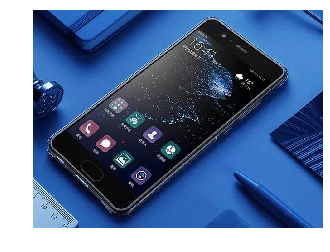

cellular telephone, cellular phone, cellphone, cell, mobile phone (score = 0.35292)
hand-held computer, hand-held microcomputer (score = 0.27418)
iPod (score = 0.07545)
radio, wireless (score = 0.05525)
modem (score = 0.03853)

images/af445f8f1b46d6083c1206eb9063533a.jpg


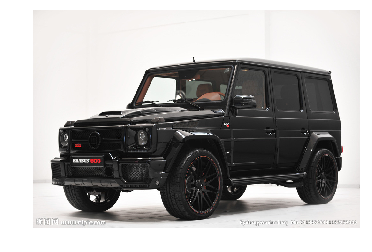

jeep, landrover (score = 0.92744)
car wheel (score = 0.00387)
pickup, pickup truck (score = 0.00386)
Model T (score = 0.00304)
limousine, limo (score = 0.00125)

images/fa15c10685a0da2b5c72744713b97d3d.jpg


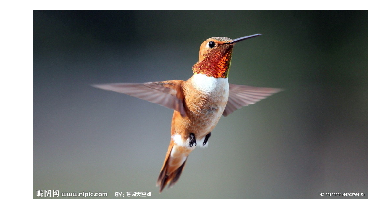

hummingbird (score = 0.95410)
bubble (score = 0.00317)
water ouzel, dipper (score = 0.00059)
jacamar (score = 0.00032)
red wine (score = 0.00022)

images/ad3c08f52f1f16e64a78aea91ceb81ee.jpg


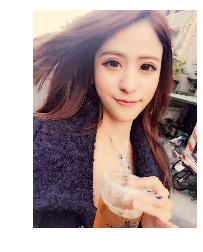

wig (score = 0.90653)
Band Aid (score = 0.00989)
hair spray (score = 0.00518)
miniskirt, mini (score = 0.00498)
perfume, essence (score = 0.00267)



In [5]:
# 建立一个图,存放google训练好的模型
with tf.gfile.FastGFile('inception_model/classify_image_graph_def.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')
    
with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    
    for root,dirs,files in os.walk('images/'):
        for file in files:
            # 载入图片
            image_data = tf.gfile.FastGFile(os.path.join(root,file), 'rb').read()
            predictions = sess.run(softmax_tensor, {'DecodeJpeg/contents:0':image_data})# 图片为jpg格式
            predictions = np.squeeze(predictions)# 把结果转为1维数据
            
            # 打印图片路径及名称
            img_path = os.path.join(root,file)
            print(img_path)
            img = Image.open(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
            
            # 预测结果为每一个类别的概率值,生序排列, 进行降序排列, 并取top5
            top_k = predictions.argsort()[-5:][::-1]
            node_lookup = NodeLookup()
            
            for node_id in top_k:
                human_string = node_lookup.id_to_string(node_id)
                score = predictions[node_id]
                print('%s (score = %.5f)'%(human_string, score))
            print()